<a href="https://colab.research.google.com/github/mingder78/500pxAPITemplateForiOS/blob/master/PCA%2BGSEA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# To do analysis for RNA-seq (microarray) samples for metadata and gene exressions related to neuroblastoma

# ✅ 1. Test correlation between each PC and each metadata variable
* Seperate metadata and genes expression into two array.
* To use PCA to downgrate dimensions of genes group to find the most associated metadata.

# ✅ 2. To find the cluster of to genes in PC3 most associated with metadata variable (mycn_status, high_risk, sex, and more)

## 🦄 Conclusion
* We found PC3, PC2, PC1 are more significants
> PC3 is strongly associated with high_risk, mycn_status, d_fav_all, and several clinical features.
> PC2 and PC1 also relate to survival (e.g., os_day, efs_day), indicating different biological axes.

* Show heatmaps for significant clinical features
> 🧬 3. Gene-Level Observations

>> Certain genes like RPL37A, RPS27A, EIF3P5, etc. show increased expression in high-risk samples.
These may be candidates for further investigation (e.g., differential expression analysis or survival association).

# ✅ 3. Run pre-ranked GSEA:
## 🦄 Conclusion

# Step 1: Import necessary libraries

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import ttest_ind, pearsonr, f_oneway
import numpy as np

In [6]:
# create correlate_pcs_with_metadata function
def correlate_pcs_with_metadata(pca_df, metadata_columns, max_pc=10):
    results = []

    for pc in [f"PC{i+1}" for i in range(max_pc)]:
        for col in metadata_columns:
            values = pca_df[col].dropna()
            pc_values = pca_df.loc[values.index, pc]

            if pd.api.types.is_numeric_dtype(values):
                # Continuous variable → Pearson correlation
                r, p = pearsonr(pc_values, values)
                results.append((pc, col, "correlation", r, p))

            else:
                groups = [pc_values[values == lvl] for lvl in values.unique()]
                if len(groups) == 2:
                    stat, p = ttest_ind(groups[0], groups[1])
                    results.append((pc, col, "t-test", stat, p))
                elif len(groups) > 2:
                    stat, p = f_oneway(*groups)
                    results.append((pc, col, "ANOVA", stat, p))
                else:
                    continue  # Skip degenerate variables

    return pd.DataFrame(results, columns=["PC", "Metadata", "Test", "Statistic", "P-value"]).sort_values("P-value")


# Step 2: Load data
## Expression data: the rows are meta data and gene exression p-value, columns are samples

## optional files (with different sizes)
* https://raw.githubusercontent.com/mingder78/ngs-2025/refs/heads/main/df_output.csv
* https://raw.githubusercontent.com/mingder78/ngs-2025/refs/heads/main/df_output-11-lines.csv
* https://raw.githubusercontent.com/mingder78/ngs-2025/refs/heads/main/df_output-101-lines.csv
* https://raw.githubusercontent.com/mingder78/ngs-2025/refs/heads/main/df_output-201-lines.csv

## datatset source
https://ftp.ncbi.nlm.nih.gov/geo/series/GSE62nnn/GSE62564/matrix/

In [7]:
df = pd.read_csv("https://raw.githubusercontent.com/mingder78/ngs-2025/refs/heads/main/df_output.csv", index_col=0)
df_clean = df[df["mycn_status"].isin(["mycn_amp", "mycn_nonamp"])].copy()

# Step 2.1: Separate metadata and expression matrix

In [8]:
metadata = df_clean.iloc[:, :17]      # Adjust this to match metadata column count
expression = df_clean.iloc[:, 17:]    # Everything after metadata is gene expression
metadata = metadata.drop(columns=["id", "train_valid_set"])

In [9]:
# Check the result
#print("Metadata preview:\n", metadata.head())
print("Expression preview:\n", expression.head())

Expression preview:
             61E3.4     A1BG  A1BG-AS1     A1CF       A2M    A2ML1  A3GALT2P  \
gene                                                                          
gsm1205238  989.12  2048.00    873.10   814.63  23170.47  1067.48     40.22   
gsm1205239  948.83  1136.20    140.07  1217.75  27175.14  1884.54     25.63   
gsm1205240  580.04  2005.85    324.03  1478.58  21321.19  1332.57    110.66   
gsm1205241  442.64  2368.90    749.61   494.56  47314.67   975.50     28.84   
gsm1205242  749.61  1871.53    427.57   734.18  22851.48  1024.00      4.29   

            A4GALT   A4GNT     AAAS  ...     ZW10   ZWILCH     ZWINT    ZXDA  \
gene                                 ...                                       
gsm1205238  216.77   91.14  2105.58  ...  1438.15  2778.33  13307.94  149.09   
gsm1205239  266.87  131.60  3040.30  ...  1618.01  3104.19  13587.57  315.17   
gsm1205240  112.21  102.54  2336.28  ...  1332.57  1509.65   8779.97  179.77   
gsm1205241  123.64   59.3

In [10]:
expression_data = expression.T
expression_data.head()

gene,gsm1205238,gsm1205239,gsm1205240,gsm1205241,gsm1205242,gsm1205243,gsm1205244,gsm1205245,gsm1205246,gsm1205247,...,gsm1205726,gsm1205727,gsm1205728,gsm1205729,gsm1205730,gsm1205731,gsm1205732,gsm1205733,gsm1205734,gsm1205735
61E3.4,989.12,948.83,580.04,442.64,749.61,643.59,661.68,704.28,685.02,760.08,...,477.71,240.52,388.02,487.75,600.49,576.03,855.13,504.95,576.03,643.59
A1BG,2048.00,1136.20,2005.85,2368.90,1871.53,2503.97,1296.14,3169.41,1541.37,3191.46,...,2019.81,2957.17,508.46,2225.63,1573.76,996.00,1520.15,1595.73,2019.81,1260.69
A1BG-AS1,873.10,140.07,324.03,749.61,427.57,643.59,560.28,515.56,218.28,491.14,...,238.86,522.76,151.17,294.07,467.88,498.00,709.18,349.71,724.08,413.00
A1CF,814.63,1217.75,1478.58,494.56,734.18,935.76,1418.35,410.15,729.11,436.55,...,63.56,125.37,233.94,215.27,388.02,259.57,903.89,304.44,227.54,349.71
A2M,23170.47,27175.14,21321.19,47314.67,22851.48,25180.16,55108.99,23987.58,17682.08,13873.08,...,20882.40,34636.37,18179.19,27939.14,27939.14,61147.25,66450.85,32768.00,64633.75,92041.70


# Step 3: Normalize / scale expression data

In [11]:
n_pc = 40 #need to change for different sample size 10 ~ 40

In [12]:
scaler = StandardScaler()
scaled_expr = scaler.fit_transform(expression)

pca = PCA(n_components=n_pc)
pcs = pca.fit_transform(scaled_expr)

pca_df = pd.DataFrame(pcs, columns=[f"PC{i+1}" for i in range(pcs.shape[1])], index=expression.index)
pca_df = pca_df.join(metadata)

In [13]:
#pca_df

#✅ 2. Test correlation between each PC and each metadata variable

## Here’s a flexible function that does this for both:

* categorical metadata (via t-tests or ANOVA)
* numerical metadata (via Pearson correlation)

## in d_fav_all
* ✅ 有利（Favorable）：
*  指病患在臨床上被預測為預後較好、存活率較高、對治療反應較佳的一群。
* ❌ 不利（Unfavorable）：
*  則是預測為預後較差、可能對治療反應差、生存率較低、復發風險高的一群。

In [14]:
metadata_columns = metadata.columns.tolist()
correlation_results = correlate_pcs_with_metadata(pca_df, metadata_columns, max_pc=10)
print(correlation_results.head(10))

/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:580: SmallSampleWarning: all input arrays have length 1.  f_oneway requires that at least one input has length greater than 1.
  if is_too_small(samples, kwds):
<ipython-input-6-05f13ee06035>:21: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  stat, p = f_oneway(*groups)


     PC            Metadata         Test  Statistic       P-value
36  PC3         mycn_status       t-test -14.369079  2.473797e-39
34  PC3           high_risk       t-test  12.569199  1.309864e-31
29  PC3           d_fav_all        ANOVA  57.231638  4.596306e-23
24  PC2              os_day  correlation  -0.389359  2.706967e-19
20  PC2           high_risk       t-test   9.063640  3.010317e-18
35  PC3          inss_stage        ANOVA  23.663574  6.654317e-18
10  PC1              os_day  correlation   0.374773  6.921213e-18
18  PC2             efs_day  correlation  -0.368785  2.499259e-17
30  PC3  death_from_disease       t-test   8.637309  8.115251e-17
37  PC3              os_bin       t-test   8.637309  8.115251e-17


# filter out p-value < (a small number) 0.0.5 to 0.000000005



In [15]:
significant_results = correlation_results[correlation_results["P-value"] < 6.921213e-17]
significant_results

,PC,Metadata,Test,Statistic,P-value
36,PC3,mycn_status,t-test,-14.369079,2.473797e-39
34,PC3,high_risk,t-test,12.569199,1.309864e-31
29,PC3,d_fav_all,ANOVA,57.231638,4.596306e-23
24,PC2,os_day,correlation,-0.389359,2.706967e-19
20,PC2,high_risk,t-test,9.063640,3.010317e-18
35,PC3,inss_stage,ANOVA,23.663574,6.654317e-18
10,PC1,os_day,correlation,0.374773,6.921213e-18
18,PC2,efs_day,correlation,-0.368785,2.499259e-17


# ✅ What above results say:
## PC3 is strongly associated with high_risk, mycn_status, d_fav_all, and several clinical features.

## PC2 and PC1 also relate to survival (e.g., os_day, efs_day), indicating different biological axes.

# 🧬 1. Get Top Genes by PCA Loadings

# The following Scree Plot
## tells you how much of the total variance each PC captures.

# PC4 or P2、PC3 與 mycn_status 以及 d_fav_all 都有顯著相關性

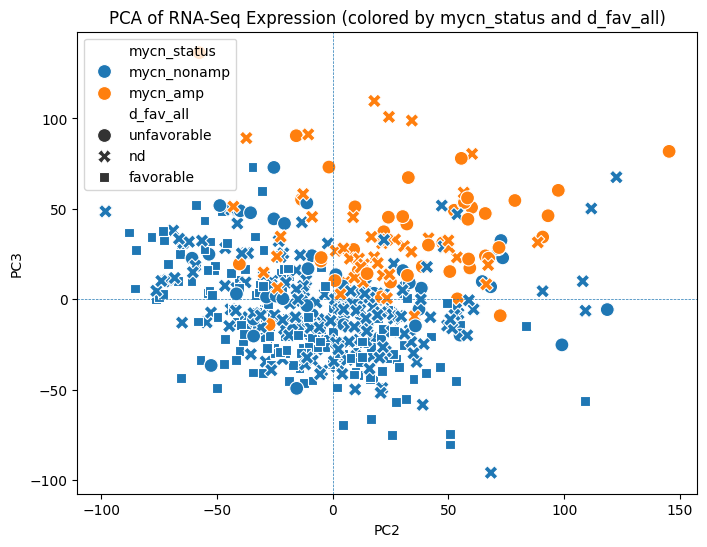

In [16]:
# Step 5: Plot PCA colored by MYCN status
plt.figure(figsize=(8,6))
sns.scatterplot(data=pca_df, x="PC2", y="PC3", hue="mycn_status", style="d_fav_all", s=100)
plt.title("PCA of RNA-Seq Expression (colored by mycn_status and d_fav_all)")
plt.axhline(0, ls="--", lw=0.5)
plt.axvline(0, ls="--", lw=0.5)
plt.show()

In [17]:
import plotly.graph_objects as go
import pandas as pd

# Assuming pca_df exists and has columns: PC2, PC3, PC1, mycn_status
# Example mapping to colors
color_map = {"mycn_amp": "red", "mycn_nonamp": "blue"}
colors = pca_df["mycn_status"].map(color_map)

# Create the 3D scatter plot
fig = go.Figure()

# Optionally, plot each group separately for a legend
for status in pca_df["mycn_status"].unique():
    df_group = pca_df[pca_df["mycn_status"] == status]
    fig.add_trace(go.Scatter3d(
        x=df_group["PC2"],
        y=df_group["PC3"],
        z=df_group["PC1"],
        mode="markers",
        marker=dict(
            size=5,
            color=color_map[status],
            opacity=0.8
        ),
        name=status  # For legend
    ))

# Customize layout
fig.update_layout(
    title="Interactive 3D PCA Plot",
    scene=dict(
        xaxis_title="PC2",
        yaxis_title="PC3",
        zaxis_title="PC1"
    ),
    width=800,
    height=700
)

fig.show()


# 📈 Optional: Show explained variance


## To decide how many PCs are useful:
* explained_var.cumsum() up to 80% - 90%

In [18]:
explained_var = pca.explained_variance_ratio_
print("Explained variance:", explained_var)
print("Cumulative:", explained_var.cumsum())

Explained variance: [0.27528392 0.07977443 0.0512957  0.04262934 0.02629282 0.02230962
 0.02099506 0.01635907 0.01502271 0.01431361 0.01217595 0.01129931
 0.01020024 0.00945912 0.00856338 0.00806491 0.00755629 0.00712143
 0.00683334 0.00658611 0.00630916 0.00604096 0.00570955 0.00525368
 0.00496228 0.00479865 0.00474668 0.00446621 0.00432774 0.00421801
 0.00417503 0.00404252 0.00391256 0.00376116 0.00367827 0.00357569
 0.00350104 0.00343067 0.00325791 0.00318777]
Cumulative: [0.27528392 0.35505835 0.40635406 0.4489834  0.47527622 0.49758584
 0.51858089 0.53493997 0.54996267 0.56427628 0.57645223 0.58775154
 0.59795179 0.6074109  0.61597429 0.62403919 0.63159548 0.63871691
 0.64555025 0.65213636 0.65844552 0.66448647 0.67019603 0.67544971
 0.68041199 0.68521064 0.68995732 0.69442353 0.69875126 0.70296928
 0.7071443  0.71118682 0.71509938 0.71886054 0.72253881 0.7261145
 0.72961554 0.73304621 0.73630412 0.73949189]


# If a PC explains <1% of variance, it's likely unimportant.

# explained_var.cumsum() better up to 80% - 90%

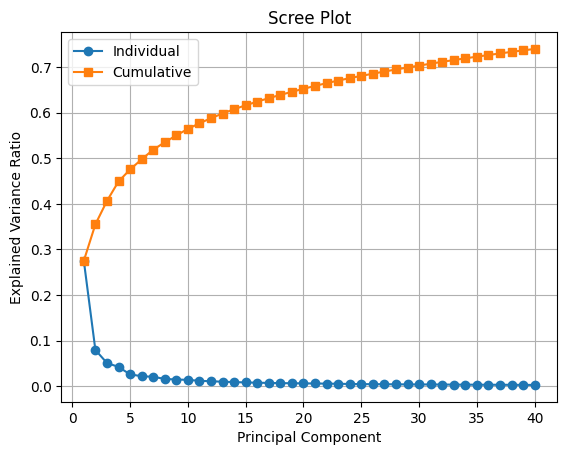

In [19]:
plt.plot(range(1, len(explained_var)+1), explained_var, marker='o', label='Individual')
plt.plot(range(1, len(explained_var)+1), explained_var.cumsum(), marker='s', label='Cumulative')
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.title("Scree Plot")
plt.legend()
plt.grid(True)
plt.show()

# Auto test PCs to find associations

# ✅ Helper: Test PC–Metadata Associations
## example:
* metadata_fields = ["mycn_status", "high_risk", "os_day", "inss_stage", "d_fav_all"]
* metadata_fields = ["mycn_status", "d_fav_all", "age_at_diagnosis", "death_from_disease", 	"efs_bin", 	"efs_day" ,"high_risk" , "inss_stage", 	"os_bin", "os_day", "progression" ,	"sex", 	"train_valid_set"]


In [20]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind, f_oneway, pearsonr
from sklearn.preprocessing import LabelEncoder

def test_pc_metadata_associations(pca_df, metadata_fields, n_pcs=5):
    """
    Automatically test association between the top N PCs and metadata fields.
    Works for binary, categorical, and numeric metadata.

    Parameters:
    - pca_df: DataFrame with PC columns and metadata joined (PC1, PC2, ..., plus metadata columns)
    - metadata_fields: list of metadata column names
    - n_pcs: number of PCs to test (default=5)

    Prints p-values of association tests.
    """
    results = []

    for field in metadata_fields:
        values = pca_df[field]

        for pc in [f"PC{i+1}" for i in range(n_pcs)]:
            pc_values = pca_df[pc]

            if values.nunique() == 2:
                # Binary field: use t-test
                groups = [pc_values[values == v] for v in values.unique()]
                stat, pval = ttest_ind(*groups, equal_var=False)
                test = "t-test"
            elif values.dtype.kind in "if":  # numeric field
                # Use Pearson correlation
                stat, pval = pearsonr(pc_values, values)
                test = "Pearson"
            else:
                # Categorical with >2 groups: use ANOVA
                groups = [pc_values[values == v] for v in values.unique()]
                stat, pval = f_oneway(*groups)
                test = "ANOVA"

            results.append({
                "PC": pc,
                "Metadata": field,
                "Test": test,
                "P-Value": pval
            })

    results_df = pd.DataFrame(results).sort_values("P-Value")
    #display(results_df)
    return results_df


In [21]:
metadata_fields = ["mycn_status", "d_fav_all", "age_at_diagnosis", "death_from_disease", 	"efs_bin", 	"efs_day" ,"high_risk" , "inss_stage", 	"os_bin", "os_day", "progression" ,	"sex"]

test_pc_metadata_associations(pca_df, metadata_fields, n_pcs=20)


,PC,Metadata,Test,P-Value
2,PC3,mycn_status,t-test,1.925231e-27
122,PC3,high_risk,t-test,3.297942e-26
22,PC3,d_fav_all,ANOVA,4.596306e-23
181,PC2,os_day,Pearson,2.706967e-19
142,PC3,inss_stage,ANOVA,6.654317e-18
...,...,...,...,...
99,PC20,efs_bin,t-test,9.660859e-01
219,PC20,progression,t-test,9.660859e-01
191,PC12,os_day,Pearson,9.783839e-01
192,PC13,os_day,Pearson,9.876519e-01


# Select how many top genes (top_n) need to be inspect for each PC

In [22]:
top_n = 30 # 30 ~ 500

In [23]:
# genes = columns in expression matrix
gene_names = expression.columns
components = pd.DataFrame(pca.components_, columns=gene_names, index=[f"PC{i+1}" for i in range(pca.n_components)])

# Create a dict of top N genes (by absolute loading) per PC
top_genes_by_pc = {}

for pc in components.index:
    loadings = components.loc[pc]
    top_genes = loadings.abs().sort_values(ascending=False).head(top_n).index
    top_genes_by_pc[pc] = loadings[top_genes].sort_values(ascending=False)  # signed values

# Example: show top 10 genes for PC1

list_of_pc = [f"PC{i+1}" for i in range(pca.n_components)]
#list_of_pc = ['PC3']

def print_top_genes(list_of_pc):
    for pc in list_of_pc:
        print(f"Top genes for {pc}:")
        print(top_genes_by_pc[pc])
        print()

#print_top_genes(list_of_pc)

In [24]:
top_genes = top_genes_by_pc['PC3'].index.tolist()

# 🧪 2. Extract Expression Data for Top Genes

## expression_data shape: (genes, samples)
## If shape is (samples, genes), transpose first

In [25]:
expr_top_genes = expression_data.loc[top_genes]  # genes x samples
expr_top_genes = expr_top_genes.T  # samples x genes
expr_top_genes

,CD3EAP,LOC392387,LOC120364,VAX2,HMGB3P11,BEST4,HMGB3P1,TFAP4,RPS17P1,RPL27AP2,...,RPS2P45,HMGB3P27,FANCB,HSPD1P10,EEF1B2P5,LINC00839,RPS17P6,RPS7P8,RPS7P14,PAICS
gene,,,,,,,,,,,,,,,,,,,,,
gsm1205238,843.36,166.57,7858.29,11.39,146.02,2033.85,1978.24,45.89,1360.57,2740.08,...,8023.41,1351.18,393.44,657.11,340.14,229.13,2120.22,51776.15,418.77,7804.01
gsm1205239,1652.00,288.01,6746.86,657.11,588.13,3666.02,4299.64,167.73,996.00,1332.57,...,7750.10,2646.74,792.35,1038.30,173.65,5634.22,1770.57,33689.23,494.56,9345.14
gsm1205240,1089.92,203.66,19483.97,250.73,296.11,4608.24,3104.19,70.03,4067.71,6562.36,...,13216.02,2194.99,254.23,2134.97,298.17,7332.05,6608.01,97966.44,2817.11,19082.99
gsm1205241,621.67,150.12,7231.10,187.40,100.43,3019.30,2288.20,43.11,1184.45,1305.15,...,10586.95,1937.53,213.78,1045.52,104.69,8779.97,1782.89,32316.87,340.14,11113.30
gsm1205242,568.10,136.24,6208.38,219.79,100.43,2486.67,2486.67,50.21,1458.23,2134.97,...,9026.81,1951.00,304.44,1144.10,137.19,6841.04,1833.01,35119.87,464.65,16270.83
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gsm1205731,367.09,56.89,4544.80,12.91,26.72,1152.06,843.36,25.81,781.45,1448.16,...,5518.27,786.88,79.34,648.07,34.53,109.90,855.13,20594.91,146.02,4770.75
gsm1205732,477.71,91.77,6038.61,53.08,33.83,2134.97,1184.45,53.82,1024.00,1509.65,...,5518.27,1045.52,160.90,749.61,67.65,85.63,1226.22,27364.16,274.37,6517.03
gsm1205733,477.71,99.73,8364.13,40.22,64.89,1418.35,1652.00,36.76,1120.56,1652.00,...,5442.30,1520.15,261.38,1045.52,62.68,54.19,1584.71,44762.41,382.68,8480.89


#🧷 3. Add Metadata (e.g., high_risk)

## Assume metadata has sample IDs as index matching expr_top_genes


 # target_field can be any of bellow, need binary or yes and no
 > metadata_fields = ["mycn_status", "d_fav_all", "age_at_diagnosis", "death_from_disease", 	"efs_bin", 	"efs_day" ,"high_risk" , "inss_stage", 	"os_bin", "os_day", "progression" ,	"sex"]

 ## # if you change target_field, need to change following 'yes' or 'no' to your new field status


In [26]:
#target_field = 'mycn_status' or 'high_risk', etc. status
target_field = 'd_fav_all'
expr_with_meta = expr_top_genes.copy()
expr_with_meta[target_field] = metadata.loc[expr_top_genes.index, target_field]
expr_with_meta[target_field]

,d_fav_all
gene,
gsm1205238,unfavorable
gsm1205239,unfavorable
gsm1205240,unfavorable
gsm1205241,nd
gsm1205242,unfavorable
...,...
gsm1205731,favorable
gsm1205732,favorable
gsm1205733,nd


In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create row colors based on `high_risk` or others target_field status
## if you change target_field, need to change following 'yes' or 'no' to your new field status

#🔥 4. Plot Heatmap with Clustering


# 🚀 Heatmap for top genes (groups) associate to high_risk (in PC3)




In [28]:
def plot_heatmap_for_pc3(target_field, red, blue):
  expr_with_meta = expr_top_genes.copy()
  expr_with_meta[target_field] = metadata.loc[expr_top_genes.index, target_field]
  row_colors = expr_with_meta[target_field].map({
    red: 'red',
    blue: 'blue'
  }) if target_field in expr_with_meta.columns else None

  # Drop metadata for clustering
  data_only = expr_with_meta.drop(columns=[target_field])

  # Plot
  sns.clustermap(
    data_only,
    row_colors=row_colors,
    cmap="vlag",
    standard_scale=1,  # normalize per gene
    figsize=(12, 10),
    xticklabels=True,
    yticklabels=False
  )
  plt.title(f'Heatmap of Top {top_n} PC3 Genes')
  plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:560: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.

/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:560: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



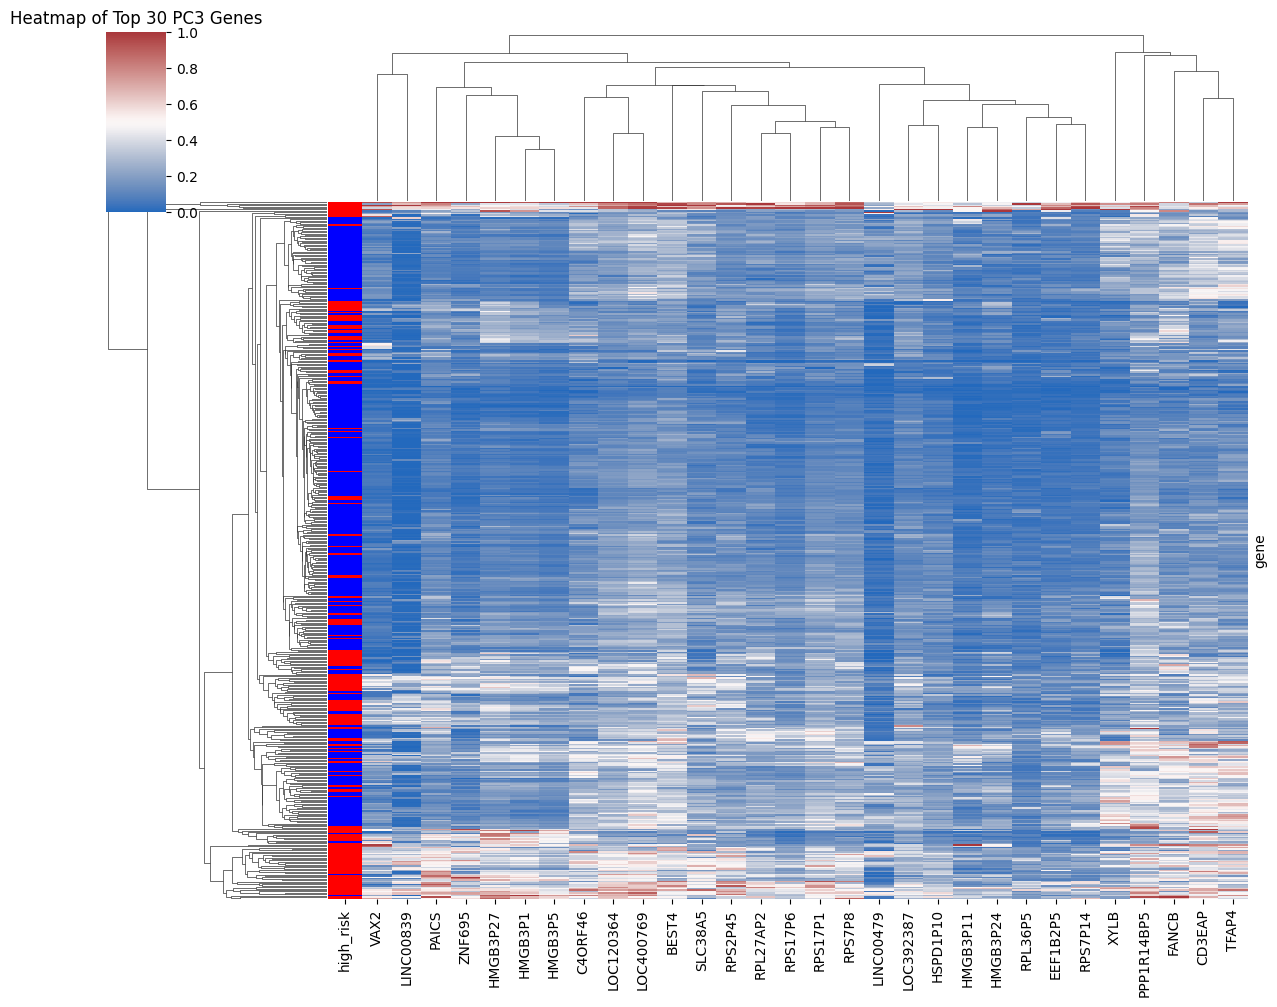

In [29]:
plot_heatmap_for_pc3('high_risk', "yes", "no")

# This heatmap shows the expression levels of the top 30 genes contributing to PC3 across all samples, with samples grouped by their `high_risk` status (red = high risk, blue = not high risk). Here's what you can interpret:

----------

🔍 1. Clustering of Samples by Gene Expression

- The columns are genes, and the rows are samples.
- You see distinct clusters in the dendrogram at the top, suggesting that these genes separate samples into expression-based groups.
- These clusters may correlate with the `high_risk` status, as red (high risk) samples are grouped differently than blue ones.
----------

🔥 2. Association Between PC3 Genes and High Risk

- There is a clear visual pattern:
    - A block of red samples (high risk) shows higher expression (red color) of some genes on the right side of the heatmap.
    - Meanwhile, many blue samples (low risk) show lower expression (blue color) of those same genes.

This implies:

- PC3 separates samples partly based on high_risk status.
- The genes contributing to PC3 are likely biologically relevant to this clinical feature.
----------

🧬 3. Gene-Level Observations

- Certain genes like RPL37A, RPS27A, EIF3P5, etc. show increased expression in high-risk samples.
- These may be candidates for further investigation (e.g., differential expression analysis or survival association).
----------

📊 Conclusion

- The heatmap supports that PC3 captures variance strongly associated with the `high_risk` phenotype, consistent with your previous PC3 vs. metadata p-values.
- The top PC3 genes are likely involved in pathways active in high-risk tumors.

# 🚀 Heatmap for top genes (groups) associate to mycn_status (in PC3)



/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:560: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.

/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:560: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



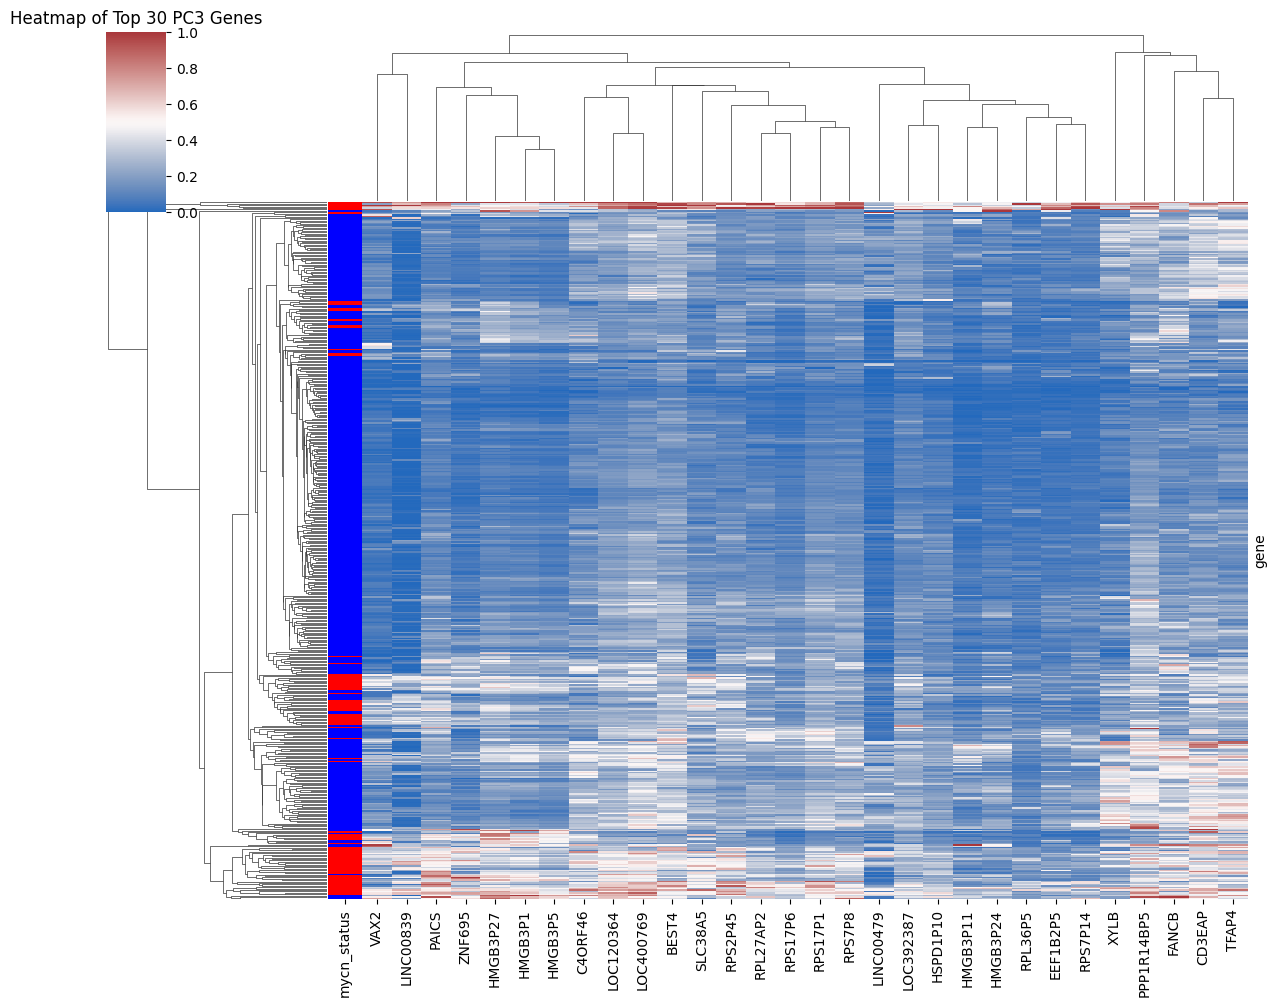

In [30]:
plot_heatmap_for_pc3('mycn_status', "mycn_amp", "mycn_nonamp")

# 🚀 Heatmap for top genes (groups) associate to d_fav_all (in PC3)



/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:560: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.

/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:560: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



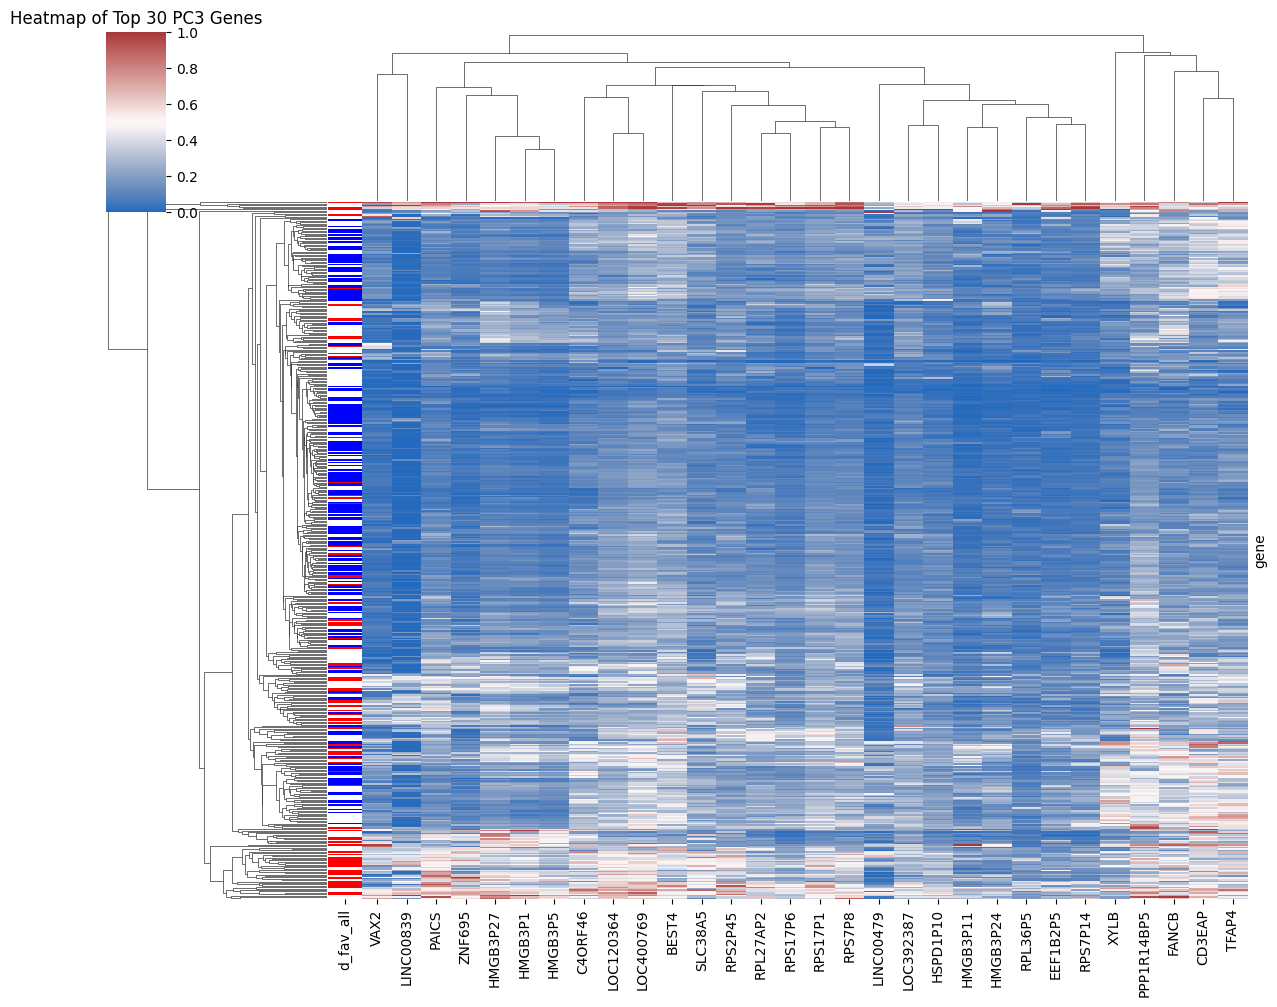

In [31]:
plot_heatmap_for_pc3( "d_fav_all", 'unfavorable', "favorable")

# based on these tops genes for PC3

In [84]:
# Top PC3 genes
top_genes = 500

pc3_loadings = components.loc['PC3']
top_positive = pc3_loadings.sort_values(ascending=False).head(top_genes)
top_negative = pc3_loadings.sort_values(ascending=True).head(top_genes)

# Save for GSEA or DE analysis
top_positive.to_csv("pc3_positive.rnk", sep="\t", header=False)
top_negative.to_csv("pc3_negative.rnk", sep="\t", header=False)

# ✅ Suggested GSEA Strategy

    Run GSEA (preranked) separately on:

      *  pc3_positive.rnk → genes contributing to positive PC3 direction.

      *  pc3_negative.rnk → genes contributing to negative PC3 direction.

## This will show:

  *  Which biological processes/pathways drive high PC3 scores (e.g. MYCN-amplified)

  * Which ones are enriched in low PC3 scores (e.g. non-MYCN)

# Run pre-ranked GSEA:

In [36]:
!pip install gseapy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 597.6/597.6 kB 13.0 MB/s eta 0:00:00


In [85]:
import gseapy as gp

# Perform preranked GSEA (e.g. with Reactome, KEGG, GO)
pre_res_positive = gp.prerank(
    rnk="pc3_positive.rnk",
    gene_sets="GO_Biological_Process_2021", #"KEGG_2021_Human",  # or "GO_Biological_Process_2021"
    outdir="gsea_pc3_pos",
    min_size=5, # 1 - 5
    max_size=100, # 100 - 2000
    permutation_num=100, # 100 - 10000, can increase for publication
    seed=42
)

# To see top pathways:
print(pre_res_positive.res2d.head(10))


      Name                                               Term        ES  \
0  prerank    central nervous system development (GO:0007417)  0.629873   
1  prerank  regulation of transcription initiation from RN... -0.925553   
2  prerank  cellular macromolecule biosynthetic process (G...   0.29962   
3  prerank                      ncRNA processing (GO:0034470)  0.382536   
4  prerank                rRNA metabolic process (GO:0016072)  0.382536   
5  prerank                       rRNA processing (GO:0006364)  0.382536   
6  prerank  maturation of 5.8S rRNA from tricistronic rRNA...  0.778672   
7  prerank               cytoplasmic translation (GO:0002181)   0.33543   
8  prerank  regulation of mitotic metaphase/anaphase trans... -0.772636   
9  prerank           purine nucleobase transport (GO:0006863) -0.933735   

        NES NOM p-val FDR q-val FWER p-val  Tag %  Gene %  \
0  2.026316       0.0  0.389986        0.2    5/6  24.00%   
1 -1.906305       0.0  0.740031       0.43    3/3   

# negative.rnk


In [86]:
# Perform preranked GSEA (e.g. with Reactome, KEGG, GO)
pre_res_negative = gp.prerank(
    rnk="pc3_negative.rnk",
    gene_sets="GO_Biological_Process_2021", #"KEGG_2021_Human",  # or "GO_Biological_Process_2021"
    outdir="gsea_pc3_neg",
    min_size=3, # 1 - 5
    max_size=100, # 100 - 2000
    permutation_num=100, # 100 - 10000, can increase for publication
    seed=42
)

# To see top pathways:
print(pre_res_negative.res2d.head(10))


      Name                                               Term        ES  \
0  prerank  positive regulation of mitophagy in response t... -0.981891   
1  prerank            glycogen metabolic process (GO:0005977) -0.851107   
2  prerank      regulation of receptor recycling (GO:0001919) -0.927565   
3  prerank  negative regulation of neuron apoptotic proces... -0.785302   
4  prerank  positive regulation of mitochondrial outer mem...   0.78672   
5  prerank  negative regulation of fat cell differentiatio...  0.830986   
6  prerank   negative regulation of neuron death (GO:1901215) -0.656856   
7  prerank  endoplasmic reticulum to Golgi vesicle-mediate...  0.521385   
8  prerank  negative regulation of nucleic acid-templated ...  0.337799   
9  prerank  negative regulation of cellular macromolecule ...  0.337799   

        NES NOM p-val FDR q-val FWER p-val Tag %  Gene %  \
0 -2.119643       0.0  0.344508       0.25   3/3   2.60%   
1 -1.950178       0.0  0.620115       0.59   3/3  15.6



| Column | Meaning |

| `Name` | The method used: `prerank` means you ran GSEA on a ranked list of genes. |

| `Term` | The name of the gene set (e.g., GO term, KEGG pathway). |

| `ES` (Enrichment Score) | Indicates whether genes from the gene set are enriched at the top (positive ES) or bottom (negative ES) of your ranked list. |

| `NES` (Normalized ES) | ES normalized by gene set size. Allows comparison across gene sets. |

| `NOM p-val` (Nominal p-value) | Raw significance of the enrichment score. |

| `FDR q-val` | Adjusted p-value accounting for multiple testing (False Discovery Rate). |

| `FWER p-val` | Family-Wise Error Rate (more conservative than FDR). |

| `Tag %` | Percentage of genes in the gene set that were actually found in your ranked list and contributed to the ES. |

| `Gene %` | Proportion of your ranked list that contributed to the enrichment signal. |

| `Lead_genes` | Genes most strongly contributing to the enrichment score. |

